# Real estate price prediction.
Это курсовой проект. 

Октябрь 2021 (27.09 - 12.10).

Белов Алексей.

**Задание:**
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры города N).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

**Целевая переменная:**
Price

**Метрика качества:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score).

**Требования к решению:**
1. R2 > 0.65
2. Тетрадь Jupyter Notebook с кодом решения, названная по образцу {ФИО}_solution.ipynb.
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv.
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

**Сроки сдачи:**
Cдать проект нужно в течение 7 дней после начала последнего вебинара (12.10.2021 20:00). Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## 0. Загрузка библиотек и функций

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка данных

In [3]:
train = pd.read_csv("train.csv", index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')
print('Данные загружены.')

Данные загружены.


In [4]:
print(f"Тренировочный набор: {train.shape[0]} квартир и {train.shape[1]} признаков")
print(f'Тестовый набор: {test.shape[0]} квартир и {test.shape[1]} признаков')

Тренировочный набор: 10000 квартир и 19 признаков
Тестовый набор: 5000 квартир и 18 признаков


**Описание датасета:**
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

## 2. Приведение типов данных

In [7]:
train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Привожу Rooms и HouseFloor к int, ставлю DistrictId как категориальный признак**

In [8]:
# train['Rooms'] = train['Rooms'].astype('int64')
# test['Rooms'] = test['Rooms'].astype('int64')

# train['HouseFloor'] = train['HouseFloor'].astype('int64')
# test['HouseFloor'] = test['HouseFloor'].astype('int64')

train['DistrictId'] = train['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   object 
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

## 3. Обзор данных

### Price

In [11]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

Average: 214138.86 
Median: 192269.64


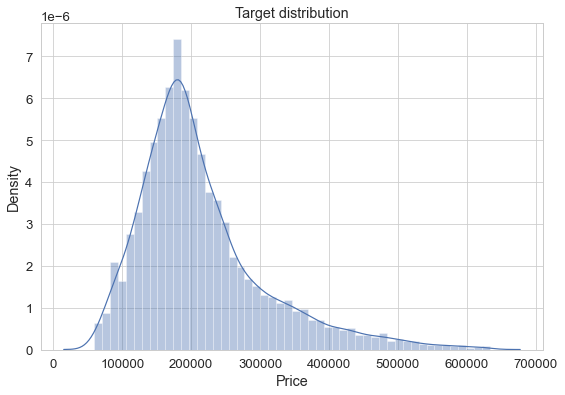

In [12]:
plt.figure(figsize = (9, 6))

sns.distplot(train['Price'])
plt.title('Target distribution')

print('Average: %.2f' % train['Price'].mean(),'\n'
      'Median: %.2f' %train['Price'].median())

### Количественные переменные

In [13]:
train.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [14]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [15]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,"5,000.00","5,000.00","3,959.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","2,623.00","5,000.00","5,000.00"
mean,1.91,56.45,36.16,5.98,8.63,12.60,"1,984.39",0.12,24.93,"5,406.90",8.26,"1,146.66",1.32,4.24
std,0.84,19.09,17.83,9.95,5.48,6.79,18.57,0.12,17.53,"4,026.61",23.86,"1,044.74",1.48,4.78
min,0.00,1.38,0.33,0.00,1.00,0.00,"1,908.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,1.00,41.91,23.09,1.00,4.00,9.00,"1,973.00",0.02,6.00,"1,564.00",0.00,325.00,0.00,1.00
50%,2.00,52.92,32.93,6.00,7.00,12.00,"1,977.00",0.07,25.00,"5,285.00",2.00,900.00,1.00,3.00
75%,2.00,66.29,45.17,9.00,12.00,17.00,"2,000.00",0.20,36.00,"7,287.00",5.00,"1,548.00",2.00,6.00
max,17.00,223.45,303.07,620.00,78.00,99.00,"2,020.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00


In [16]:
feature_num_names = train.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

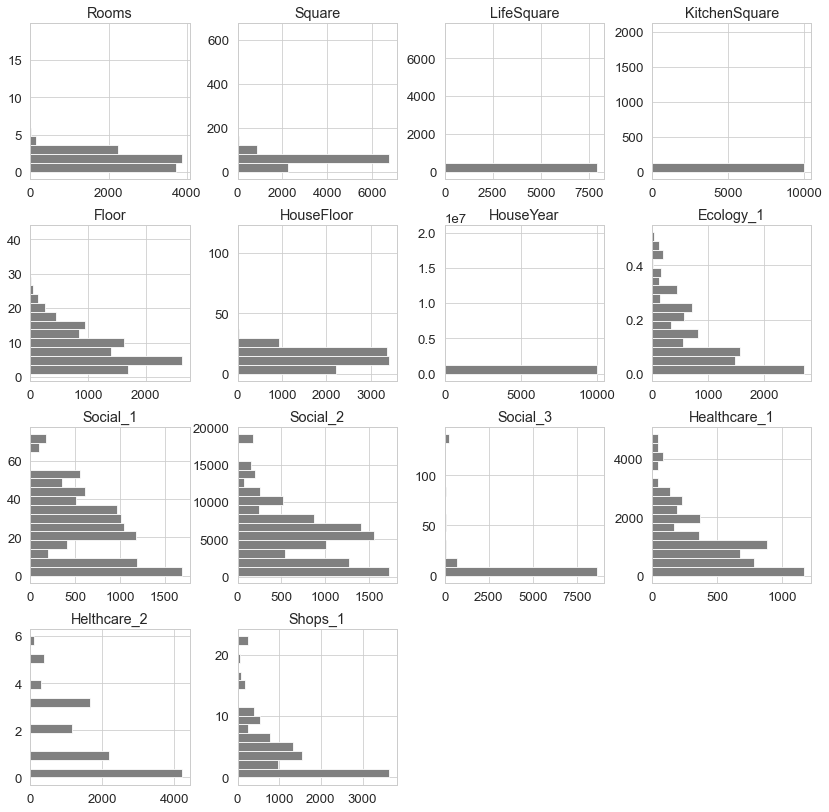

In [17]:
train[feature_num_names].hist(figsize=(14,14), bins=16, grid=True, orientation='horizontal', color="grey", ec="white");

### Категориальные переменные 

In [18]:
feature_cat_names = train.drop('Price', axis=1).select_dtypes(include=['object']).columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [19]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [20]:
train.corr()['Price'].sort_values()

Ecology_1       -0.06
HouseYear        0.00
KitchenSquare    0.03
Social_3         0.07
LifeSquare       0.08
HouseFloor       0.09
Floor            0.13
Healthcare_1     0.14
Shops_1          0.18
Social_2         0.24
Helthcare_2      0.25
Social_1         0.26
Square           0.52
Rooms            0.55
Price            1.00
Name: Price, dtype: float64

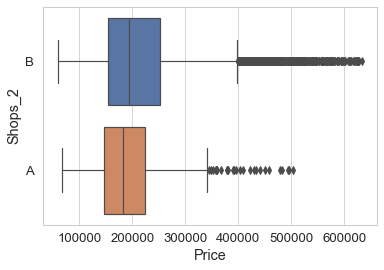

In [21]:
sns.boxplot('Price', 'Shops_2', data=train);

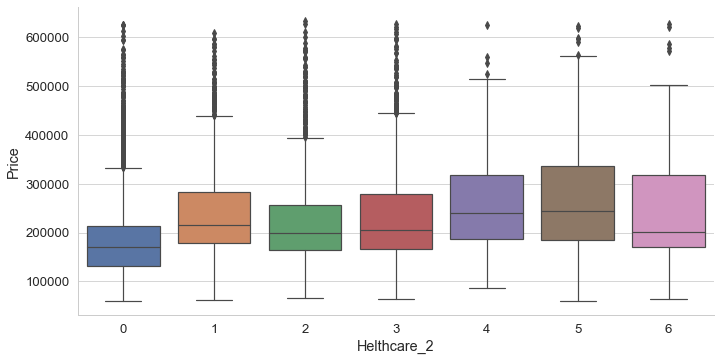

In [22]:
sns.catplot('Helthcare_2', 'Price', kind="box", data=train, aspect=2/1);

In [23]:
train['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [24]:
test['Helthcare_2'].value_counts()

0    2096
1    1096
3     855
2     570
5     186
4     158
6      39
Name: Helthcare_2, dtype: int64

**Упрощу Helthcare_2 до трех "категорий" по количеству значений и боксплоту**

In [25]:
train['Helthcare_2'] = train['Helthcare_2'].replace({1:1, 2:1, 3:1, 4:2, 5:2, 6:2})

test['Helthcare_2'] = test['Helthcare_2'].replace({1:1, 2:1, 3:1, 4:2, 5:2, 6:2})

## 4. Обработка пропусков

In [26]:
train.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### LifeSquare - замена на медиану 

In [27]:
train['LifeSquare'].mean(), train['LifeSquare'].median()

(37.19964482767308, 32.781260192155735)

In [28]:
train['LifeSquare'] = train['LifeSquare'].fillna(train['LifeSquare'].median())

test['LifeSquare'] = test['LifeSquare'].fillna(train['LifeSquare'].median())

train.isna().sum()[train.isna().sum() != 0]

Healthcare_1    4798
dtype: int64

### Healthcare_1

**Обучаю модель по Healthcare_2**

Создаю копию $\text{Healthcare_1}$.

$\text{H2}$ будет содержать значения $\text{Healthcare_2}$ для квартир, у которых $\text{Healthcare_1}$ не пропущена.

$\text{H1}$ - для этих же квартир известная $\text{Healthcare_1}$.

$\text{H2_nan}$ - значения Healthcare_2, у которых $\text{Healthcare_1}$ пропущена.

In [29]:
train['Healthcare_1_copy'] = train['Healthcare_1']

H2 = train.loc[train['Healthcare_1_copy'].notna(), ['Helthcare_2']]

H1 = train.loc[train['Healthcare_1_copy'].notna(), 'Healthcare_1_copy']

H1.shape, H2.shape

((5202,), (5202, 1))

In [30]:
H2_nan = train.loc[train['Healthcare_1_copy'].isna(), ['Helthcare_2']]
H2_nan.shape

(4798, 1)

In [31]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X=H2, y=H1)

preds = lr.predict(H2_nan)

In [32]:
train.loc[train['Healthcare_1_copy'].isna(), ['Healthcare_1_copy']] = preds

**Те же действия с тестовым датасетом**

In [33]:
test['Healthcare_1_copy'] = test['Healthcare_1']

H2_test = test.loc[test['Healthcare_1_copy'].notna(), ['Helthcare_2']]

H1_test = test.loc[test['Healthcare_1_copy'].notna(), 'Healthcare_1_copy']

H2_nan_test = test.loc[test['Healthcare_1_copy'].isna(), ['Helthcare_2']]

H1_test.shape, H2_test.shape, H2_nan_test.shape

((2623,), (2623, 1), (2377, 1))

In [34]:
lr_test = LinearRegression()

lr_test.fit(X=H2_test, y=H1_test)

preds_test = lr.predict(H2_nan_test)

In [35]:
test.loc[test['Healthcare_1_copy'].isna(), ['Healthcare_1_copy']] = preds_test

In [36]:
train['Healthcare_1_copy'].isna().sum()

0

In [37]:
test['Healthcare_1_copy'].isna().sum()

0

### 4. Обработка выбросов

In [38]:
train.describe()

# Housefloor, rooms, square, houseyear

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Healthcare_1_copy
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,36.27,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",0.66,4.23,"214,138.86","1,083.75"
std,0.84,21.06,76.61,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",0.62,4.81,"92,872.29",747.14
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78",0.00
25%,1.00,41.77,25.53,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63",830.00
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64",902.34
75%,2.00,65.90,41.43,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",1.00,6.00,"249,135.46","1,178.83"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",2.00,23.00,"633,233.47","4,849.00"


**Года - замена некорректных значений**

In [39]:
train.loc[train['HouseYear'] > 2022]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
10814,109,1.00,37.27,20.24,9.00,9,12.00,20052011,0.14,B,B,30,6141,10,262.00,1,6,B,"254,084.53",262.00
11607,147,2.00,44.79,28.36,5.00,4,9.00,4968,0.32,B,B,25,4756,16,"2,857.00",2,8,B,"243,028.60","2,857.00"


In [40]:
# train.loc[train['HouseYear'] < 1888]

In [41]:
# test.loc[test['HouseYear'] > 2021]

In [42]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2011
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

**HouseFloor и Floor**

In [43]:
# train.loc[train['Floor'] == 0] #нет

In [44]:
train.loc[train['HouseFloor'] > 50]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
10806,5,1.00,51.94,48.71,1.00,6,99.00,1977,0.15,B,B,16,3433,4,"2,643.00",2,5,B,"296,127.12","2,643.00"
9300,74,2.00,71.75,74.58,9.00,5,99.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,"243,329.91",902.34
78,30,2.00,65.77,66.81,1.00,8,117.00,1977,0.00,B,B,22,6398,141,"1,046.00",1,23,B,"207,248.37","1,046.00"


In [45]:
test.loc[test["HouseFloor"] > 40]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,
15864,27,3.00,47.72,47.10,9.00,18,99.00,1977,0.07,B,B,2,629,1,nan,0,0,A,902.34
5707,76,2.00,73.36,38.74,5.00,38,48.00,2010,0.00,B,B,7,1660,39,"1,786.00",1,5,B,"1,786.00"
414,76,2.00,67.61,41.18,5.00,46,48.00,2002,0.00,B,B,7,1660,39,"1,786.00",1,5,B,"1,786.00"
1397,76,3.00,221.14,118.06,4.00,32,48.00,2011,0.00,B,B,7,1660,39,"1,786.00",1,5,B,"1,786.00"


Для этажей больше 50 - простое решение

In [46]:
train.loc[train['HouseFloor'] == 99, 'HouseFloor'] = 9
train.loc[train['HouseFloor'] == 117, 'HouseFloor'] = 17

test.loc[test['HouseFloor'] == 99, 'HouseFloor'] = 9

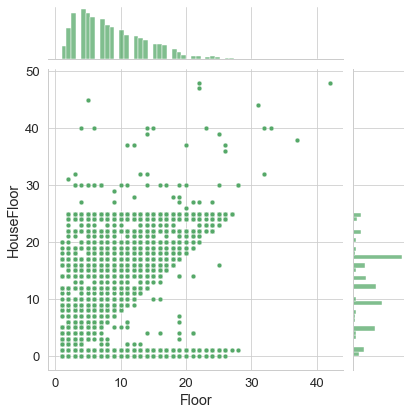

In [47]:
import seaborn as sns

sns.jointplot(train['Floor'], train['HouseFloor'], kind='scatter', height=6, color='g');

In [48]:
train.loc[train['HouseFloor'] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
11993,74,2.00,80.31,32.78,0.00,14,0.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,"221,244.16",902.34
6641,54,3.00,118.91,32.78,0.00,2,0.00,1977,0.01,B,B,30,5285,0,645.00,2,6,B,"571,069.05",645.00
4378,27,3.00,106.96,0.64,0.00,17,0.00,2018,0.07,B,B,2,629,1,nan,0,0,A,"337,299.87",902.34
9371,23,2.00,60.50,32.78,0.00,16,0.00,1977,0.03,B,B,0,168,0,nan,0,0,B,"229,778.06",902.34
10521,38,3.00,104.21,106.34,0.00,20,0.00,2017,0.06,B,B,15,2787,2,520.00,0,7,B,"435,462.05",520.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302,30,1.00,46.07,48.31,0.00,4,0.00,1977,0.00,B,B,22,6398,141,"1,046.00",1,23,B,"161,403.09","1,046.00"
9384,59,3.00,98.61,32.78,0.00,14,0.00,1977,0.02,B,B,37,7687,11,176.00,2,5,B,"492,700.26",176.00
11441,62,2.00,71.99,72.45,0.00,5,0.00,1977,0.07,B,B,2,629,1,nan,0,0,A,"158,841.62",902.34


In [49]:
test.loc[test['HouseFloor'] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,
12694,27,3.00,83.67,46.36,0.00,8,0.00,2015,0.07,B,B,2,629,1,nan,0,0,A,902.34
8968,27,2.00,69.85,32.78,0.00,3,0.00,1977,0.01,B,B,4,915,0,nan,0,0,B,902.34
2982,6,2.00,63.46,32.78,0.00,13,0.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B,540.00
2449,1,1.00,66.43,32.78,0.00,14,0.00,1977,0.01,B,B,1,264,0,nan,0,1,B,902.34
12309,45,1.00,42.90,32.78,0.00,25,0.00,1977,0.20,B,B,23,5212,6,nan,1,2,B,"1,178.83"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10262,27,2.00,69.20,32.78,0.00,10,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B,902.34
12116,88,3.00,89.55,32.78,0.00,20,0.00,1977,0.13,B,B,43,8429,3,nan,1,9,B,"1,178.83"
16357,58,1.00,49.21,32.78,0.00,4,0.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"1,084.00"


Если нули - замена на медиану

In [50]:
train.loc[train['HouseFloor'] == 0] = train['HouseFloor'].median()

test.loc[test['HouseFloor'] == 0] = train['HouseFloor'].median()

train.loc[train['HouseFloor'] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,


Если Floor больше HouseFloor - меняю их местами

In [51]:
train.loc[train['Floor'] > train['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
10953,27,1.00,53.77,52.41,1.00,5,4.00,1977,0.07,B,B,2,629,1,nan,0,0,A,"140,647.57",902.34
2119,27,2.00,49.36,31.99,5.00,6,5.00,1983,0.05,B,B,5,1227,0,nan,0,0,B,"117,000.38",902.34
11935,27,2.00,64.71,32.78,1.00,15,1.00,1977,0.21,B,B,9,1892,0,nan,0,1,B,"127,200.03",902.34
6486,200,3.00,85.28,58.45,9.00,6,5.00,1960,0.00,B,B,33,7425,1,nan,1,5,B,"402,871.92","1,178.83"
10103,94,1.00,35.28,23.35,6.00,11,9.00,1971,0.28,B,B,33,8667,2,nan,0,6,B,"148,862.21",902.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,52,3.00,64.07,47.63,6.00,11,9.00,1983,0.37,B,B,34,7065,1,750.00,1,5,B,"226,434.88",750.00
16159,27,1.00,38.97,32.78,1.00,10,1.00,1977,0.21,B,B,9,1892,0,nan,0,1,B,"95,529.57",902.34
4145,96,3.00,90.06,47.86,11.00,26,24.00,2005,0.04,B,B,53,14892,4,nan,1,4,B,"441,108.91","1,178.83"


In [52]:
test.loc[test['Floor'] > test['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,
15856,74,2.00,69.26,32.78,1.00,6,1.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,902.34
15975,61,3.00,64.54,42.65,7.00,10,9.00,1981,0.30,B,B,52,10311,6,nan,1,9,B,"1,178.83"
5214,27,1.00,37.56,32.78,1.00,5,1.00,1977,0.21,B,B,9,1892,0,nan,0,1,B,902.34
11160,58,1.00,48.61,48.75,1.00,4,3.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"1,084.00"
9348,205,1.00,37.48,16.85,8.00,6,5.00,1933,0.17,B,B,19,3856,10,nan,1,5,B,"1,178.83"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15181,27,4.00,104.66,66.90,1.00,4,1.00,2016,0.02,B,B,2,469,0,nan,0,0,B,902.34
16064,30,1.00,38.38,37.00,1.00,2,1.00,1977,0.00,B,B,22,6398,141,"1,046.00",1,23,B,"1,046.00"
2591,39,2.00,44.20,30.19,6.00,10,9.00,1972,0.43,B,B,25,5011,8,730.00,0,2,B,730.00


In [53]:
train.loc[train['Floor'] > train['HouseFloor'], 'Floor'] = train['HouseFloor']
train.loc[train['HouseFloor'] < train['Floor'], 'HouseFloor'] = train['Floor']

test.loc[test['Floor'] > test['HouseFloor'], 'Floor'] = test['HouseFloor']
test.loc[test['HouseFloor'] < test['Floor'], 'HouseFloor'] = test['Floor']

In [54]:
test.loc[test['Floor'] > test['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,


**Теперь Rooms**

In [55]:
train['Rooms'].value_counts()

2.00     3780
1.00     3598
3.00     2181
13.00     269
4.00      147
5.00       17
0.00        4
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

Больше 5 - замена на медиану

0 - Замена на медиану

In [56]:
train.loc[train['Rooms'] > 5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
11993,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
6641,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
4378,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
9371,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
10521,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
9384,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00
11441,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13,13.00,13.00,13.00,13,13,13,13.00,13,13,13.00,13.00,13.00


In [57]:
train.loc[train['Rooms'] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
12638,27,0.00,138.43,136.22,0.00,3.00,3.00,2016,0.08,B,B,11,3097,0,nan,0,0,B,"268,394.74",902.34
7917,27,0.00,212.93,211.23,0.00,2.00,3.00,2008,0.21,B,B,9,1892,0,nan,0,1,B,"302,211.26",902.34
3159,88,0.00,38.70,19.35,9.00,9.00,16.00,1982,0.13,B,B,43,8429,3,nan,1,9,B,"158,998.11","1,178.83"
9443,27,0.00,87.76,85.13,0.00,5.00,15.00,1977,0.21,B,B,9,1892,0,nan,0,1,B,"219,281.92",902.34


In [58]:
train.loc[train['Rooms'] == 0, 'Rooms'] = train['Rooms'].median()
train.loc[train['Rooms'] > 5, 'Rooms'] = train['Rooms'].median()

test.loc[test['Rooms'] == 0, 'Rooms'] = train['Rooms'].median()
test.loc[test['Rooms'] > 5, 'Rooms'] = train['Rooms'].median()

Теперь надо разобраться с **Square, LifeSquare, KitchenSquare:**

In [59]:
train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,54.96,35.69,6.61
std,21.83,76.67,28.56
min,1.14,0.37,0.00
25%,41.15,23.72,1.00
50%,51.44,32.78,6.00
75%,65.41,41.25,9.00
max,641.07,"7,480.59","2,014.00"


Допустим, для кухни 120 метров это много.

И больше 333 квадратов в общем.

А жилую площадь можно представить как их разность (лимит в 200м).

Замена на медиану.

In [60]:
train.loc[(train['KitchenSquare'] > 120) | (train['Square'] > 350) | (train['LifeSquare'] > 200) , :]

# по комнатам можно догадаться об ошибке

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_copy
Id,,,,,,,,,,,,,,,,,,,,
14990,23,2.00,48.45,263.54,5.00,5.00,5.00,1972,0.08,B,B,6,1437,3,nan,0,2,B,"141,780.23",902.34
14656,62,1.00,47.10,46.45,"2,014.00",1.00,1.00,2014,0.07,B,B,2,629,1,nan,0,0,A,"108,337.48",902.34
7917,27,2.00,212.93,211.23,0.00,2.00,3.00,2008,0.21,B,B,9,1892,0,nan,0,1,B,"302,211.26",902.34
5548,86,5.00,275.65,233.95,26.00,12.00,37.00,2011,0.16,B,A,31,7010,5,"4,508.00",1,7,B,"455,264.88","4,508.00"
28,9,2.00,604.71,32.78,1.00,17.00,18.00,1977,0.16,B,B,25,5648,1,30.00,1,4,B,"187,717.24",30.00
16550,27,3.00,81.69,"7,480.59",1.00,9.00,17.00,2016,0.02,B,B,2,469,0,nan,0,0,B,"217,357.49",902.34
2307,102,1.00,409.43,410.64,10.00,4.00,4.00,2016,0.24,B,B,26,3889,6,705.00,1,6,B,"90,470.43",705.00
11602,30,2.00,641.07,638.16,10.00,19.00,19.00,2019,0.00,B,B,22,6398,141,"1,046.00",1,23,B,"133,529.68","1,046.00"
15886,85,3.00,78.06,461.46,10.00,12.00,16.00,1998,0.04,B,B,52,11217,1,"2,300.00",1,7,B,"394,253.30","2,300.00"


In [61]:
train.loc[(train['KitchenSquare'] > 120), 'KitchenSquare'] = train['KitchenSquare'].median()
# test.loc[(test['KitchenSquare'] > 120), 'KitchenSquare'] = train['KitchenSquare'].median()

train.loc[(train['LifeSquare'] > 200), 'LifeSquare'] = train['LifeSquare'].median()
# test.loc[(test['LifeSquare'] > 200), 'LifeSquare'] = train['LifeSquare'].median()

train.loc[(train['Square'] > 333), 'Square'] = train['Square'].median()
# test.loc[(test['Square'] > 333), 'Square'] = train['Square'].median()

# интересно что в тестовом датасете таких ошибок нет

### 12. Создание модели

In [62]:
# train.to_csv('train_prepared.csv')
# test.to_csv('test_prepared.csv')

In [63]:
features = train.columns
features.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Healthcare_1_copy']

In [64]:
features = ['Rooms',
#  'DistrictId',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
#  'Ecology_2',
#  'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
#  'Healthcare_1',
#  'Healthcare_1_copy',
 'Helthcare_2',
 'Shops_1']
#  'Shops_2']

target = ['Price']

In [65]:
X = train[features]
y = train[target]

len(features) 

13

In [66]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
#                                                     test_size=0.33, 
#                                                     shuffle=True, 
#                                                     random_state=42)
# print(X_train.shape, y_train.shape)
# print(X_valid.shape, y_valid.shape)

In [67]:
forest = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)

print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.75647


#### Важность признаков 

In [68]:
forest.fit(X, y)
importances = forest.feature_importances_
feature_importances = pd.Series(importances, index=features)
feature_importances.sort_values(ascending=True, inplace=True)

<AxesSubplot:>

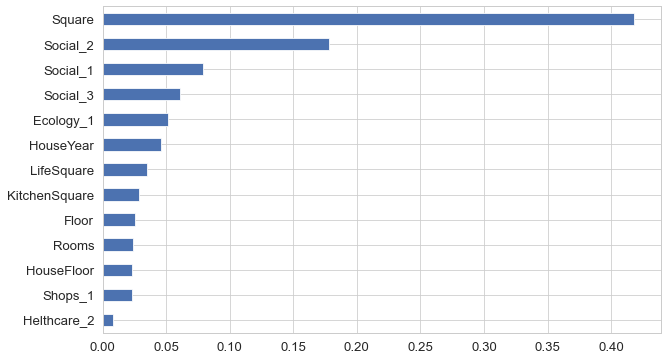

In [69]:
feature_importances.plot(kind='barh', figsize=(10, 6))

Честно говоря, меня настолько устраивает значение $\text{0.75647}$, что не рискну улучшать, разбирать признаки и проч и проч.

## Прогноз на тестовом датасете 

In [70]:
y_pred = forest.predict(test[features])
# predictions = pd.DataFrame(y_pred)
# predictions.head()

In [71]:
predictions = pd.DataFrame()
predictions['Id'] = test.index
predictions['Price'] = y_pred
predictions.head()

,Id,Price
0,725,"166,293.48"
1,15856,"204,897.60"
2,5480,"195,513.90"
3,15664,"353,967.22"
4,14275,"138,834.77"


In [73]:
predictions.to_csv('submission_16.csv', index=False)